In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [86]:
ALPHA = 0.01
EPOCHS = 1000

In [88]:
def fn_plot_samples(samples,m ,n):
    fig, axes = plt.subplots(figsize=(n*2, m*2),
                           nrows = m, ncols=n,
                           sharey = True, sharex = True)
    for ax, img , in zip(axes.flatten(), samples):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.imshow(1-img.reshape((3,3)), cmap = 'Greys_r')
    return fig,axes

In [90]:
def fn_sigmoid(x):
    return 1/(1.0+np.exp(-x))

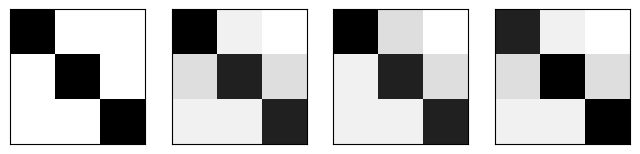

In [92]:
#Examples of faces 
faces = [np.array([1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]),
         np.array([0.9, 0.1, 0.0, 0.2, 0.8, 0.2, 0.1, 0.1, 0.8]),
         np.array([0.9, 0.2, 0.0, 0.1, 0.8, 0.2, 0.1, 0.1, 0.8]),
         np.array([0.8, 0.1, 0.0, 0.2, 0.9, 0.2, 0.1, 0.1, 0.9]),
         np.array([0.8, 0.1, 0.0, 0.1, 0.9, 0.2, 0.1, 0.1, 0.9])]
_= fn_plot_samples(faces,1,4)

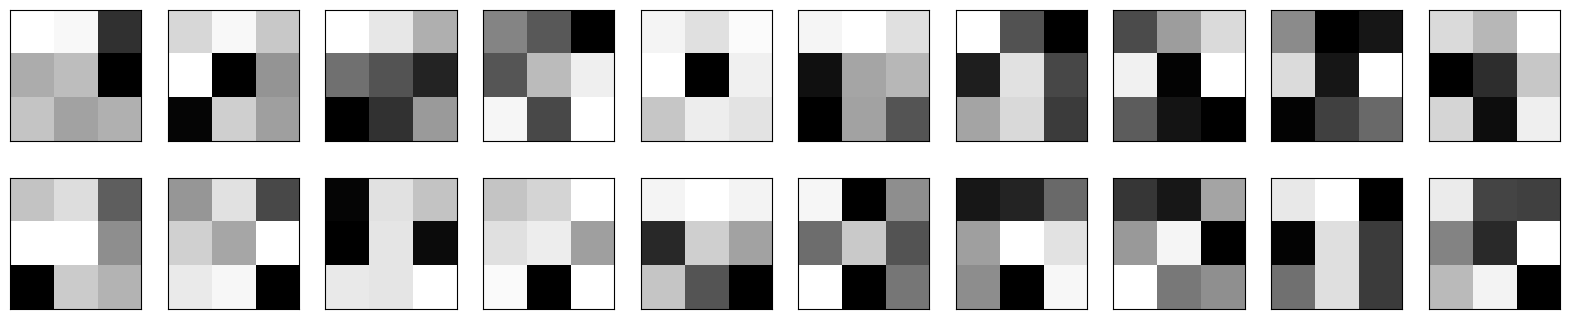

In [94]:
noise = [np.random.random((3,3)).round(2) for i in range(20)]

_= fn_plot_samples(noise, 2,10)

In [95]:
nn_input_dim = 9
class Discriminator():
    def __init__(self):
        self.weights = np.random.randn(nn_input_dim) / np.sqrt(nn_input_dim)
        self.bias = 0.0

    def forward(self, x):
        return fn_sigmoid(np.dot(x, self.weights) +self.bias)

    def image_error(self, image):
        predication = self.forward(image)
        return -np.log(predication)

    def derivatives_from_image(self, image):
        y_pred = self.forward(image)
        dW = image * (y_pred- 1)
        db = y_pred - 1
        return dW, db

    def update_from_image(self, x):
        dW, db = self.derivatives_from_image(x)
        self.weights -= ALPHA * dW
        self.bias -= ALPHA * db

    def noise_error(self, noise):
        y_pred= self.forward(noise)
        return -np.log(1-y_pred)

    def derivatives_from_noise(self, noise):
        y_pred = self.forward(noise)
        dW = noise * (y_pred- 1)
        db = y_pred - 1
        return dW, db

    def update_from_noise(self, x):
        dW, db = self.derivatives_from_noise(noise)
        self.weights -= ALPHA * dW
        self.bias -= ALPHA * db
       

In [98]:
class Generator():

    def __init__(self):
        self.weights = np.random.randn(nn_input_dim) / np.sqrt(nn_input_dim)
        self.biases = np.zeros(nn_input_dim)

    def forward(self, z):
        return fn_sigmoid(z * self.weights + self.biases)

    def error(self, z, discriminator):
        x = self.forward(z)
        y = discriminator.forward(x)
        return -np.log(y)

    def derivatives(self, z , discriminator):
        discriminator_weights = discriminator.weights
        discriminator_bias = discriminator.bias
        x = self.forward(z)
        y = discriminator.forward(x)

        factor = - (1-y) *  discriminator_weights * x * (1 - x)
        dW = factor * z 
        db = factor
        return dW, db

    def update(self, z , discriminator):
        dW, db = self.derivatives(z, discriminator)
        self.weights -= ALPHA * dW
        self.biases -= ALPHA * db

In [100]:
D = Discriminator()
G = Generator()

errors_discriminator, error_generator = [],[]

for epoch in range(EPOCHS):
    for face in faces:
        D.update_from_image(face)
        z = np.random.randn()
        errors_discriminator.append(sum(D.image_error(face) + D.noise_error(z)))
        error_generator.append(G.error(z, D))
        noise = G.forward(z)
        D.update_from_noise(noise)
        G.update(z, D)

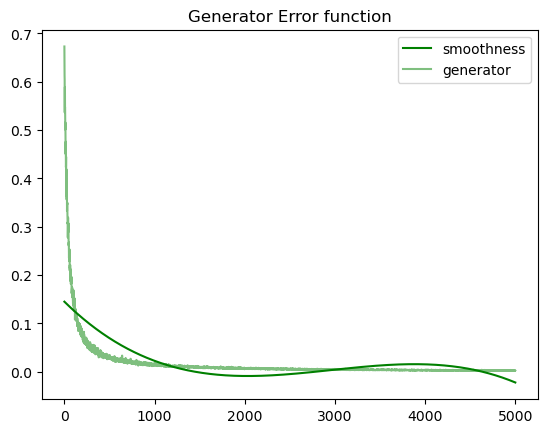

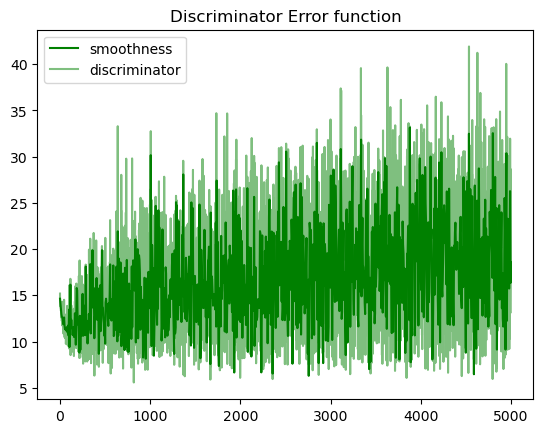

In [102]:
from scipy.interpolate import UnivariateSpline

xnew = np.linspace(0 , len(error_generator)- 1, 1000)
spl = UnivariateSpline(range(len(error_generator)), error_generator)
plt.plot(xnew, spl(xnew), '-', c= 'g', label = 'smoothness')
plt.plot(error_generator, alpha= 0.5, c= 'g', label= 'generator')
plt.title('Generator Error function')
plt.legend()
plt.show()

xnew = np.linspace(0 , len(errors_discriminator)- 1, 1000)
spl = UnivariateSpline(range(len(errors_discriminator)), errors_discriminator)
plt.plot(xnew, spl(xnew), '-', c= 'g', label = 'smoothness')
plt.plot(errors_discriminator, alpha= 0.5, c= 'g', label= 'discriminator')
plt.title('Discriminator Error function')
plt.legend()
plt.show()

In [ ]:
generated_images = []
for i in range(100):
    
    z = np.random.random() # generate a random number
    
    generated_image = G.forward(z) # call forward method of Generator class
    
    generated_images.append(generated_image)